In [2]:
# Dmporting required libraries
import string
import math as m
import itertools as iTools
from nupack import *
import matplotlib.pyplot as plt

# Defining the toehold switch complex analysis model
thsModel = Model(material = "rna", celsius = 37)

# Dictionary input miRNA sequences and names
miRNADict = {'asd': 'UCCUGUACUGAGCUGCCCCGAG', 'fgh': 'AUCCCACCUCUCACCAGC', 'jkl': 'UGUGCAAAUCCAUGCAAAACUGA'}
# miRNADict = {'asd': 'UCCUGUACUGAGCUGCCCCGAG'}
miRNADictVals = []

# Dictionary defining complimentary base pairing (no wobble pairing present)
baseDict = {"A":"U", "C":"G"}

# List of bases
baseList = ["A", "U", "C", "G"]

# list of and regions that will be in the centre of and gate strands, these sections will bind to the toehold switch while the rest of the and gate will bind to the 2 miRNA strands it will connect
andRegions = ("AAAAAA", "UUUUUU", "CCCCCC", "GGGGGG")

# List of strands, strands is simply the miRNA strands in the order inputted or the order being tried by the iterate() function followed by the and gates
# orderedStrands is the strands list reordered by listAddition() to be passed to NUPACK's functions to form orderd strand complexes
strands = []
orderedStrands = []

#list of domain names for NUPACK
domains = list((string.ascii_lowercase))

#list of complex.seq
seq = []

# Number of iterations, incrimented recursively to get best possible ths
iterCount = 0

# List of toehold switch objects, the class for which is defined below
thsObjs = []

# Best scores for the miRNA-and gate complex from each iteration 
minScoreList = []

# MiRNA complex structure generated by code
complexStructure = []

# Class for the toehold switch, one is created each iteration, contains all the important information for the switch, strucEnergy property is an object from NUPACK
class ToeholdSwitch:
    def __init__(self, strucEnergy, toehold, duplex, sequence, exposure, strandsUsed, triggerStruc, thsSamples, triggerSamples):
        self.strucEnergy = strucEnergy
        self.toehold = toehold
        self.duplex = duplex
        self.sequence = sequence
        self.exposure = exposure
        self.strandsUsed = strandsUsed
        self.triggerStruc = triggerStruc
        self.thsSamples = thsSamples
        self.triggerSamples = triggerSamples

    # Display method, never called in the code but useful to quickly see the most important stats of the ths
    def display(self):
        print(f"this switch has this structure {self.strucEnergy.structure} ({self.strucEnergy.energy}), this toehold {self.toehold}, this duplex {self.duplex}, this sequence {self.sequence}, and this exposure {self.exposure}, using these strands {self.strandsUsed}, with this trigger structure {self.triggerStruc}")
        
# Computes complimentary strand according to base pairing rules
def compStrand(rnaStrand):
    compliment = ""
    for i in rnaStrand:
        for key, value in baseDict.items():
            if i == key:
                compliment += value
            elif i == value:
                compliment += key
    return compliment

# Severses string
def reverse(rnaStrand):
  return rnaStrand[::-1]

# Splits each miRNAInput into approximate thirds and adds those to the storageArray, these parts are then used to make and gates
def splitString(miRNAInput):
    storageArray = []
    miRNAInput = miRNAInput.replace(" ","")
    n = round(len(miRNAInput)//3)
    if (len(miRNAInput) == 18):
        part1 = miRNAInput[:n]
        part2 = miRNAInput[2*n+1:]
        part3 = miRNAInput[n:2*n+1]
    else:
        part1 = miRNAInput[:n]
        part2 = miRNAInput[2*n+1:]
        part3 = miRNAInput[n:2*n+1]
    storageArray.append(compStrand(part1))
    storageArray.append(compStrand(part2))
    storageArray.append(part3)
    return storageArray

# Computes and gate
def andGateGen(sequenceDict):
   
    storageArray = []
    miRNAPartArray = []
    global unpairedMiddleArray
    unpairedMiddleArray = []
 
    # Splits the input strands into the required components for genetic and gate
    for element in miRNADictVals:
        storageArray = splitString(element)
        miRNAPartArray.append(storageArray[0])
        miRNAPartArray.append(storageArray[1])
        unpairedMiddleArray.append(storageArray[2])

    # Sakes sure code runs on the end of 1 strand and the beginning of the next strand so the and gate had ends complimentary to both
    del miRNAPartArray[0]
    del miRNAPartArray[len(miRNAPartArray)-1]
    middleIndex = 0
    for element in miRNAPartArray:

        if(miRNAPartArray.index(element) % 2==0):
            # Index is incrimented later to update the andRegion such that its adjacent base doesn't match itself
            index = 0

            # This sets the default value of the andRegion to AAAAAA
            andRegion = andRegions[index]
           
           
            # These are the parts of the and gates that bind to the toehold switch, specifically those complimentary to the miRNA
            global miRNA1, miRNA2

            miRNA1 = reverse(miRNAPartArray[miRNAPartArray.index(element)])

            miRNA2 = miRNAPartArray[miRNAPartArray.index(element) + 1]  
           
            # Checking to see if the andRegion borders an identical base and changing it to correct this by incrimenting the index, this would be a problem as the and gate complex may bind offset by 1 base
            # This only needs to be done twice as in the "worst case scenario", ALL of the below code will run, making the anndRegion different to BOTH of its neighboring bases
            if (miRNA1[-1] == andRegion[1]):
                index += 1
                andRegion = andRegions[index]
            if (reverse(miRNA2)[0] == andRegion[1]):
                index += 1
                andRegion = andRegions[index]
            if (reverse(miRNA2)[0] and miRNA1[-1] == andRegion[1]):
                index += 1
                andRegion = andRegions[index]  

            # Defining a repeating unit for the complex, doesn't include the unpaired start of the complex
            duplex1 = "D" + str(len(miRNA1)) + "+"
            complexAnd = "U" + str(len(andRegion))
            duplex2 = "D" + str(len(miRNA2)) + "+"
            unpairedMiddle = "U" + str(len(unpairedMiddleArray[middleIndex]))
       
            repeatUnit = [duplex1, complexAnd, duplex2, unpairedMiddle]      
           
            andGateDict = {}
            andGateArray = []
           
            # Construcing and gate out of end of 1 miRNA< start of the next one and the AND region in between consisting of 6 repeated bases
            andGate = miRNA1 + andRegion + reverse(miRNA2)
           
            # Strands array contains UNORDERED strands, starting with and gates, there will always be 1 fewer and gates than miRNA
            strands.append(andGate)
            middleIndex+=1#modified

            # Adding the repeat unit to the complexStructure as many times as required
            complexStructure.extend(repeatUnit)
        else:
            continue
    if (iterCount > 0):
        # This adds the NEW permutation of miRNA to miRNADictVals for the code to run on it, must be done here as opposed to start as start does this automatically but only on the first iteration
        strands.extend(miRNADictVals)
    
    # Mod3 error being corrected by force because I couldn't find another way to fix it :/
    if (len(miRNADictVals) == 3 and len(miRNADictVals[1]) == 18):
        fix = int(complexStructure[3][-1]) - 1
        complexStructure[3] = "U" + str(fix)

# Ensures correct inputs
def checkCorrectCharacters(characterList, userInput:string):
    userInput = userInput.replace(" ","")
    for element in userInput:
        if(characterList.count(element)==0):
            break
        else:
            return True
    return False

# Combines two lists together into one array so that their constituent variables appear in an alternating sequence (miRNA, AND, miRNA, AND.... miRNA)
def listAddition(array1, array2):
    # Dummy element makes the length of the list divisible by 2
    array1.append("DUMMY")
    array2 = [item for sublist in zip(array2, array1) for item in sublist]
    del array2[-1]
    del array1[-1]
   
    return array2
   

def domainOutputs():
    seq.clear()
    domainCodes = []

    for strand, domain in zip(strands, domains):
        domainCode = "domain " + domain + " = " + strand
        domainCodes.append(domainCode)

    # This takes letters of the alphabet in order until there is 1 for each miRNA and AND gate, this is so that Strand objects can be created to passed to NUPACK's algorithms
    global domainsUsed
    domainsUsed = domains[0:len(domainCodes)]

    #the domainsUsed list is split into 2 halves, one with letters to be assigned to miRNAs and the other to AND gates, for n miRNA there will be (n-1) and gates
    mid = int((len(domainsUsed) + 1)/2)
    miRNAs = list(domainsUsed[mid-1:])
    andGates = list(domainsUsed[0:mid-1])

    seq.extend(miRNAs)

    seq.extend(listAddition(andGates, seq))
    del seq[0:len(andGates)+1]
    global computedComplexStructure
    computedComplexStructure = complexStructure
    DUPlusToDPPlus(computedComplexStructure)

def toeholdSwitchGen(numMiRNA):
    # Handles generation of toehold switch
    # Assigning start and end of toeholdRegion
    global orderedStrands
    # Ordering strands using listAddition as that is the order in which the formed complex's bases will bind to the switch
    orderedStrands = listAddition(strands[0:int((len(strands)-1)/2)], strands[int((len(strands)-1)/2):int(len(strands))])
    # print(" ~~~~~~~~~~~~~~~~~~~~ ", iterCount," ~~~~~~~~~~~~~~~~~~~~ ")
    print("miRNADictVals: ", miRNADictVals)
    print("orderedStrands: ", orderedStrands)
    print("strands: ", strands)
    # This is the unpaired region of the toehold switch where the miRNA complex binds
    toehold = round((len(miRNADictVals[0])//2))
   
    # This is the unpaired part of the toehold switch the miRNA, AND GATE complex would first bind to before the switch unzips
    toeholdRegion = []
    
    unpairedStartLength = len(miRNADictVals[0]) - round((len(miRNADictVals[0])//3))
   
    if(numMiRNA !=1):
        toeholdStart = miRNADictVals[0][0:unpairedStartLength]
        toeholdEnd = miRNADictVals[-1][len(miRNA2):]
        thsAnds = []
        thsUnpaired = []
       
        for i,strand in enumerate(orderedStrands):
            # Determining AND gates in the strands list, now ordered with listAddition, then determining what AND sections are used, eg AAAAAA, GGGGGG, UUUUUU, CCCCCC and adding them to another list
            if (i % 2 == 1):
                for j in andRegions:
                    if (j in strand):
                        thsAnd = j
                        thsAnds.append(thsAnd)
                        continue
           
            # If it's not an and gate, it must be and miRNA, a distinction is made between first and final miRNA in ordered strand complexes as they will have different amount of bases paired with the switch when compared to middle miRNA
            else:
                if (i == 0):
                    # First miRNA
                    for j in andRegions:
                        if j in (orderedStrands[i+1]):
                            # Computes the part of the miRNA binding to the switch by finding the and region within the miRNA's corresponding andgate, then taking the corresponding number of bases from the miRNA
                            # u variables are components/parts of the toehold switch's toehold region which will be stuck together in the correct order to be complimentary to the unpaired bases of the and gate complex
                            u = strand[0:len(strand) - orderedStrands[i+1].find(j)]
                            thsUnpaired.append(u)
                        else:
                            continue
                elif (i == len(orderedStrands) - 1):
                    # Final miRNA
                    for j in andRegions:
                        if j in (orderedStrands[i-1]):
                            u = strand[reverse(orderedStrands[i-1]).find(j):len(orderedStrands[i-1])+3]
                            thsUnpaired.append(u)
                        else:
                            continue
                else:
                    # Middle miRNA
                    for j in andRegions:
                        if j in (orderedStrands[i-1]):
                            u1 = reverse(orderedStrands[i-1]).find(j)
                        else:
                            continue
                           
                    for j in andRegions:
                        if j in (orderedStrands[i+1]):
                            u2 = orderedStrands[i+1].find(j)
                        else:
                            continue
                           
                    u3 = strand[u1:-u2]

                    thsUnpaired.append(u3)
       
        # Reorders the ang regions used and miRNA binding regions as per listAddition            
        toeholdRegion = (listAddition(thsAnds, thsUnpaired))
       
        toeholdRegion = "".join(toeholdRegion)
       
        # length of the unpaired binding region of the ths
        toehold = 15
        thsDuplex = len(toeholdRegion) - toehold
       
        # thsDuplex is the closed/zipped part of the switch
       
        # VV IMPORTANT, MAKES THE TOEHOLD DUPLEX REGION A MULTIPULE OF 3 SO THAT ANY RNA AFTER IT CODES FOR THEIR INDENDED CODONS AND AMINO ACIDS, eg linker region and reporter protein
        if (thsDuplex % 3 == 1):
            thsDuplex = thsDuplex - 1
            toehold +=1
        elif (thsDuplex % 3 ==2):
            thsDuplex +=1
            toehold = toehold -1
           

    # Sequence of the toehold switch, mostly constructed using the computed toeholdRegion and the RBS and linker region used by CLS's Project Ribotox and First used by Dr A.Green
    toeholdSwitchSequence = (compStrand(toeholdRegion) + "GGAUUUGCAAAAAAAAGAGGAGAGUAAAAUG" + reverse(toeholdRegion)[0:thsDuplex] + "AACCUGGCGGCAGCGCAAAAG")
    print(toeholdSwitchSequence)
   
    #the entire switch structure in DU+ including the hairpin loop
    thsStructure = ("U"+ str(toehold) + "D"+ str(thsDuplex) + "(U3D5(U15)U3)U21")
    thsStrucDPP = "."*int(toehold) + "("*int(thsDuplex) + "...(((((...............)))))..." + ")"*int(thsDuplex) + "."*21
    print(str(thsStrucDPP))
   
    bindingSites = ""
    AUGs = ""
    RBSs = ""
   
    # Creating a strand object for the switch so tube analysis and boltzmann sampling can be performed
    thsStrand = Strand(str(toeholdSwitchSequence), name="toeholdSwitch")
   
    # Taking boltzmann samples to calculate RBS, AUG and toehold site exposure percentages
    thsStrandSamples = sample(strands = [thsStrand], num_sample = 50, model = thsModel)
       
    for struc in list(thsStrandSamples):       
        # Computing where RBS, AUG and toehold are located
        bindingSites += (str(struc)[0:int(toehold)])
        AUGs += (str(struc)[(int(toehold) + int(thsDuplex) + 28):(int(toehold) + int(thsDuplex) + 31)])
        RBSs += (str(struc)[(int(toehold) + int(thsDuplex) + 8):(int(toehold) + int(thsDuplex) + 23)])
   
    # Calculating the unbound percentages as an average of all such values of each boltzmann sampled structure
    global toeholdExpMin
    toeholdExpMin = 70
    global toeholdExp
    toeholdExp = (1 - (bindingSites.count("(") + bindingSites.count(")"))/len(bindingSites))*100
    AUGExp = (1 - (AUGs.count("(") + AUGs.count(")"))/len(AUGs))*100
    RBSExp = (1 - (RBSs.count("(") + RBSs.count(")"))/len(RBSs))*100
    print("Toehold binding site exposure percentage: ", toeholdExp, "%")
    print("Start codon exposure percentage: ", AUGExp, "%")
    print("Ribosome binding site exposure percentage: ", RBSExp, "%")
    if (toeholdExp < toeholdExpMin):
        print("bad")
    else:
        print("good")

    # Performing tube analysis of ths strand to get an MFE structure, NOT ALWAYS REPRESENTATIVE OF RBS, AUG AND TOEHOLD UNBOUND PERCENTAGES
    t2 = Tube(strands={thsStrand:1e-5}, complexes=SetSpec(max_size=1), name="thsTube")
    t2Result = tube_analysis(tubes=[t2], compute=["pairs", "mfe"], model = thsModel)
    print(t2Result)
    thsMFE = t2Result["(toeholdSwitch)"]
    print('\nMFE proxy structure(s) ths:')
    for i, s in enumerate(thsMFE.mfe):
        print('    %2d: %s (%.2f kcal/mol)' % (i, s.structure, s.energy))
        sampleDPP = str(s.structure)
     
    # Adding the toehold switch and its stats for THIS iteration to thsObjs list to be analysed
    thsObjs.append(ToeholdSwitch(thsMFE.mfe[0], toeholdRegion, thsDuplex, toeholdSwitchSequence, toeholdExp, list(strands), str(), list(thsStrandSamples)[0:10], list()))

    print("max exposure: ", max([x.exposure for x in thsObjs]))
    print("from this switch: ", [x.exposure for x in thsObjs].index(max([x.exposure for x in thsObjs])))
    global maxExpIdx
    
    # Finding the best toehold switch within thsObjs
    maxExpIdx = [x.exposure for x in thsObjs].index(max([x.exposure for x in thsObjs]))
   
# comverts DU+ to dot parens plus to be passed to structDiff
def DUPlusToDPPlus(computedComplexStructure):
    print(" ~~~~~~~~~~~~~~~~~~~~ ", iterCount," ~~~~~~~~~~~~~~~~~~~~ ")
    global DPPlus
    DPPlus = ""
    for i in computedComplexStructure:
        if(i[0] == "U"):
            num = int(i[1:len(i)])
            DPPlus += "."*num
            # print(DPPlus)
        else:
            num = int(i[1:-1])
            DPPlus += "("*num
            DPPlus += "+"
            DPPlus += ")"*num
    print(DPPlus)
           
# I'm aware nupack has their own version of this function, but it only operates on strand objects, this just works on strings, file containing this is the analysis file in src [I think]
def structDiff(countList, struct, DPPlus):
    counter = 0
    for a, b in zip(struct, DPPlus):
        if a != b:
            counter += 1
   
    countList.append(counter)
    return counter

def tubeDef(numMiRNA):
    countList = []
   
    # Attribute dict is a dictionary pairing each strand to a corresponding letter, these are for analysing the MFE of complexes
    attributeDict = {}

    # Strand dict is the dictionary pairing each strand object to a corresponding concentration in M to then be passed onto a tube
    strandDict = {}

    # Passing attribute dict to the Strand class' object constructor and outputting that to a strand dict
    for strand, letter in zip(strands, domainsUsed):
        attributeDict[strand] = letter
        name = letter
        strandDict[Strand(strand, name = name)] = 5e-6

    # Passing contructed strand objects to a test tube
    t1 = Tube(strands = strandDict, complexes = SetSpec(max_size = len(strands)), name = "tube 1")
   
    if(numMiRNA != 1):
        global sampledStructures
        sampledStructures = sample(strands = list(listAddition(strands[0:int((len(strands)-1)/2)], strands[int((len(strands)-1)/2):int(len(strands))])), num_sample = 50, model = thsModel)
   
    for i in range(len(sampledStructures)):
        structDiff(countList, str(sampledStructures[i]), DPPlus)
        
    # Analyses each sampled structure and adds weights to it depending o how unfavourable it is/how far away it is from the desired complex
    weightList = []
    for i in range(len(sampledStructures)):
        weightList.append(10)
   
    for i in range(len(sampledStructures)):
        indices = [[i-1, i+1] for i, x in enumerate(str(sampledStructures[i])) if x == "+"]
        if (str(sampledStructures[i]).startswith("(") or str(sampledStructures[i]).endswith(")")):
                weightList[i] += 1
        for j in indices:              
            if ((str(sampledStructures[i]))[j[0]] == "(" and (str(sampledStructures[i]))[j[-1]] == ")"):
                weightList[i] += 2.5
            else:
                weightList[i] += 5
   
    # Final score list multiplies the structure difference and weighting of each complex to achieve a final, more accurate score
    scoreList = []

    for a, b in zip(weightList, countList):
        scoreList.append(a*b)

    # Getting 10 samples for the trigger structure to be passed to a toehold switch object
    triggerSampleList = []
    orderedScoreList = sorted(scoreList)
    for i in orderedScoreList[:10]:
        triggerSampleList.append(str(sampledStructures[scoreList.index(i)]))
    thsObjs[-1].triggerSamples = list(triggerSampleList)
    
    # Getting the best structure and it's score/index
    global bestStruc
    bestStruc = str(sampledStructures[scoreList.index(min(scoreList))])
    print(bestStruc)
    thsObjs[-1].triggerStruc = str(bestStruc)
    global lowScore
    lowScore = min(scoreList)
    minScoreList.append(lowScore)
    print(min(minScoreList))
       
# Analysis to be performed on all computed toehold switches
def analysis():
    print("analysing structures...")
    # Numberical rating for each toehyold switch, takes into account the toehold switch unbind %s and the trigger structure's score
    analysisList = []
   
    # making sure no values in either of the lists are 0 as that will make the resulting value (a product of list values from both lists) 0, anomalously low
    for a,b in zip([(100 - x.exposure) for x in thsObjs], minScoreList):
        if (a == 0):
            a +=1
       
        if (b == 0):
            b +=1
   
        analysisList.append(round(a*b, 2))
       
    global bestThs
    bestThs = thsObjs[analysisList.index(min(analysisList))]
    print(bestThs)
   
    print("analysisList: ", analysisList)
    print("best score: ", str(min(analysisList)))
    print("from this index: ", str(analysisList.index(min(analysisList))))
    print("best strand order is: ", str(bestThs.strandsUsed))
   
    global strands
    strands.clear()
    strands = bestThs.strandsUsed
   
    seq.clear()
    domainCodes = []

    for strand, domain in zip(list(bestThs.strandsUsed), domains):
        domainCode = "domain " + domain + " = " + strand
        domainCodes.append(domainCode)
       
    # Creating a strand for the best ths and a complex to see the structure for the opened ths, miRNA and and gates not used here as the computation time is extremely long, especially for 3 miRNA
    bestThsStrand = Strand(str(bestThs.sequence), name = "ths")
    triggerBindingSite = Strand(reverse(str(bestThs.toehold)), name = "trigger")
    thsComplex = Complex([triggerBindingSite, bestThsStrand])
    complexSet = ComplexSet(strands={bestThsStrand: 1e-8, triggerBindingSite: 1e-8}, complexes=SetSpec(max_size=0, include=[thsComplex]))
    gap = 1.0
    global finalResult
    finalResult = complex_analysis(complexSet, compute=['pfunc', 'pairs', 'mfe', 'subopt'], options={'energy_gap': gap}, model=thsModel)
    global finalComplex
    finalComplex = finalResult[thsComplex]
   
# This function is called after every toehold switch and miRNA complex is formed, it reorders the miRNA into a different permutation and re-runs the code, then analyses all the switches generated to produce the best one
def iterate():
    global miRNADictVals
    global iterCount
    if (iterCount < m.factorial(len(miRNADictVals)) - 1):
        iterCount += 1
        strands.clear()
        orderedStrands.clear()
        miRNADictVals.clear()
        seq.clear()
        complexStructure.clear()
        for i in list(miRNAPerms[iterCount]):
            miRNADictVals.append(i)
            # print(strands)
        andGateGen(miRNADictVals)
        domainOutputs()
        toeholdSwitchGen(numMiRNA)
        tubeDef(numMiRNA)
        iterate()
    else:
        print("done")
        analysis()
       
# Start function takes a dict of {miRNA name: miRNA sequence}, it also handles all the computation for 1 strand for miRNA since there is barely any code required to do so, no and gates present
def start():  
    # print("Input the number of miRNA strands")
    global numMiRNA
    numMiRNA = len(miRNADict)
    if (numMiRNA == 1):
        print(compStrand(list(miRNADict.values())[0]))
        
        miRNA = list(miRNADict.values())[0]
        
        ths = compStrand(miRNA) + "GGAUUUGCAAAAAAAAGAGGAGAGUAAAAUG" + reverse(miRNA)[0:(len(miRNA) - 6)] + "AACCUGGCGGCAGCGCAAAAG"
        print("miRNA: ", miRNA)
        print(ths)
        thsStrand = Strand(ths, name="ths")
        miRNAStrand = Strand(miRNA, name="miRNA")

        tube = Tube(strands = {thsStrand:1e-5}, complexes=SetSpec(max_size = 1), name="thsTube")
        tubeResult = tube_analysis(tubes = [tube], compute = ["pairs", "mfe"], model=thsModel)
        thsSamples = sample(strands = [thsStrand], num_sample = 10, model = thsModel)
        
        print(tubeResult)
        thsMFE = tubeResult["(ths)"]
        print(thsMFE.mfe[0])
        print(thsMFE.mfe[0].structure)
        print(thsMFE.mfe[0].energy)
        print(str(thsMFE.mfe[0].structure)[0:6])
        thsExposure = (int(str(thsMFE.mfe[0].structure)[0:6].count("."))/6)*100
        print(thsExposure)
        print(thsSamples)
                        
        thsComplex = Complex([miRNAStrand, thsStrand])
        complexSet = ComplexSet(strands={thsStrand: 1e-8, miRNAStrand: 1e-8}, complexes=SetSpec(max_size=0, include=[thsComplex]))
        global finalResult 
        gap = 1.0
        finalResult = complex_analysis(complexSet, compute = ["pfunc", "pairs", "mfe", "subopt"], options={"energy_gap": gap}, model=thsModel)
        global finalComplex
        finalComplex = finalResult[thsComplex]
        

        global bestThs
        bestThs = ToeholdSwitch(thsMFE.mfe[0], str(), str(), ths, thsExposure, [miRNA], str(), thsSamples, str())
    else:
        miRNADictVals.extend(list(miRNADict.values()))
        andGateGen(miRNADictVals)
        domainOutputs()

    # Adds the base sequences of each miRNA and AND gate to strands to be used later
    for value in miRNADict.values():
        strands.append(value)

    if(numMiRNA != 1):
        global miRNAPerms
        miRNAPerms = list(iTools.permutations(miRNADictVals))
        toeholdSwitchGen(numMiRNA)
        tubeDef(numMiRNA)
        iterate()
start()

# This function is just to get the name of the miRNA given a sequence
def getKey(val):
    for key, value in miRNADict.items():
        if val == value:
            return key

# The 3 functions below are just used in jupyter lab to display the switches and graphs     
    
def thsDisplay():
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("toehold switch sequence and structure: ")
    print(bestThs.sequence)
    print(str(bestThs.strucEnergy.structure), " Free energy: ", str(round(bestThs.strucEnergy.energy, 2)), " (kcal/mol)")
    print("with these other possible structures")
    for x in bestThs.thsSamples:
        print(str(x))
    print("and an overall toehold region binding site exposure of: ", str(round(bestThs.exposure, 2)), "%")
    print("equilibrium probability pair matrix for toehold switch: ")
    thsPairs = pairs(strands=[str(bestThs.sequence)], model=thsModel)
    plt.imshow(thsPairs.to_array())
    plt.xlabel("Base index")
    plt.ylabel("Base index")
    plt.title("Pair probabilities for toehold switch")
    plt.colorbar()
    plt.clim(0, 1)
    plt.savefig('ths.png')    

def triggerDisplay():
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    bestThsOrderedStrands = listAddition(bestThs.strandsUsed[0:int((len(strands)-1)/2)], strands[int((len(strands)-1)/2):int(len(strands))])
    triggerMFE = mfe(strands=bestThsOrderedStrands, model=thsModel)
    triggerMFEStruc = triggerMFE[0]
    print("trigger complex strand order and structure: ")
    print(bestThsOrderedStrands)
    print("By considering Boltzmann samples: ", bestThs.triggerStruc)
    print("By considering MFE structure: ", str(triggerMFEStruc.structure), " Free energy: ", str(round(triggerMFEStruc.energy, 2)), " (kcal/nol)")
    print("with these other possible structures: ")
    for x in bestThs.triggerSamples:
        print(x)
    for i, j in enumerate(bestThsOrderedStrands):
        if (i % 2 == 1):
            print(j, " is the and gate between ", getKey(bestThsOrderedStrands[i-1]), " (", bestThsOrderedStrands[i-1], ") ", " and ", getKey(bestThsOrderedStrands[i+1]), " (", bestThsOrderedStrands[i+1], ") ")
    triggerPairs = pairs(strands=bestThsOrderedStrands, model=thsModel)
    print("equilibrium probability pair matrix for trigger complex: ")
    plt.imshow(triggerPairs.to_array())
    plt.xlabel("Base index")
    plt.ylabel("Base index")
    plt.title("Pair probabilities for trigger complex MFE")
    print("*MFE structure may not be fully representative of the trigger complex's structure, which is why Boltzmann samples are taken. If the MFE structure closely resembles the boltzmann sampled ones, it is extremely likely to form, if not it will still be possible although at lower concentrations")
    print("*Boltzmann samples will be more reliable and representative of in vitro reactions as hundreds of samples are taken, MFE structure is only taken into account to give an approximate free energy value and equilibrium pair probability matrix")
    plt.colorbar()
    plt.clim(0, 1)
    plt.savefig('trigger.png')    

def complexDisplay(): 
    print("~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~")
    print("actiavted toehold switch structure: ")
    print(str(finalComplex.mfe[0].structure), " Free energy: ", str(round(finalComplex.mfe[0].energy, 2)), " (kcal/mol)")
    print("with these other suboptimal energy structures: ")
    for x in finalComplex.subopt[:10]:
        print(x.structure, " Free energy: ", str(round(x.energy, 2)), " (kcal/mol)")
    bindingSites = ""
    for x in finalComplex.subopt:
        bindingSite = str(x.structure)[:int(str(x.structure).find("+"))]
        bindingSites += bindingSite
    print("with an activation percentage of: ", str(round(100-bindingSites.count(".")*100/len(bindingSites), 2)), "%")
    print("equilibrium probability pair matrix for activated toehold switch: ")
    plt.imshow(finalComplex.pairs.to_array())
    plt.xlabel("Base index")
    plt.ylabel("Base index")
    plt.title("Pair probabilities for activated toehold switch")
    plt.colorbar()
    plt.clim(0, 1)
    plt.savefig('complex.png')

 ~~~~~~~~~~~~~~~~~~~~  0  ~~~~~~~~~~~~~~~~~~~~ 
(((((((+)))))))......((((((+)))))).......(((((+)))))......(((((((+))))))).......
miRNADictVals:  ['UCCUGUACUGAGCUGCCCCGAG', 'AUCCCACCUCUCACCAGC', 'UGUGCAAAUCCAUGCAAAACUGA']
orderedStrands:  ['UCCUGUACUGAGCUGCCCCGAG', 'CUCGGGGAAAAAAUGGGAU', 'AUCCCACCUCUCACCAGC', 'GCUGGAAAAAAUUGCACA', 'UGUGCAAAUCCAUGCAAAACUGA']
strands:  ['CUCGGGGAAAAAAUGGGAU', 'GCUGGAAAAAAUUGCACA', 'UCCUGUACUGAGCUGCCCCGAG', 'AUCCCACCUCUCACCAGC', 'UGUGCAAAUCCAUGCAAAACUGA']
AGGACAUGACUCGACUUUUUUGGAGAGUUUUUUUUAGGUACGUUUUGAGGAUUUGCAAAAAAAAGAGGAGAGUAAAAUGUCAAAACGUACCUAAAAAAAACUCUCCAAAAAAAACCUGGCGGCAGCGCAAAAG
...............(((((((((((((((((((((((((((((((((...(((((...............)))))...))))))))))))))))))))))))))))))))).....................
Toehold binding site exposure percentage:  90.53333333333333 %
Start codon exposure percentage:  67.33333333333333 %
Ribosome binding site exposure percentage:  100.0 %
good
Complex results:
           Complex       Pfunc dG (kcal/mol) MFE (k

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
toehold switch sequence and structure: 
AGGACAUGACUCGACUUUUUUGGAGAGUUUUUUUUAGGUACGUUUUGAGGAUUUGCAAAAAAAAGAGGAGAGUAAAAUGUCAAAACGUACCUAAAAAAAACUCUCCAAAAAAAACCUGGCGGCAGCGCAAAAG
...............(((((((((((((((((((((((((((((((((.(.(((((...............))))).).)))))))))))))))))))))))))))))))))......(((....))).....  Free energy:  -55.76  (kcal/mol)
with these other possible structures
.......(...)...(((((((((((((((((((((((((((((((((.(.(((((...............))))).).)))))))))))))))))))))))))))))))))......(((....))).....
..((......))...((((((((((((((((((((((((((((.((((.(.(((((...............))))).).)))).))))))))))))))))))))))))))))......(((....))).....
...............(((((((((((((((((((((((((((((((((.(.(((((...............))))).).)))))))))))))))))))))))))))))))))......(((....))).....
...............(((((.(((((((((((((((((((((((((((.(.(((((...............))))).).))))))))))))))))))))))))))).)))))......(((....))).....
...........

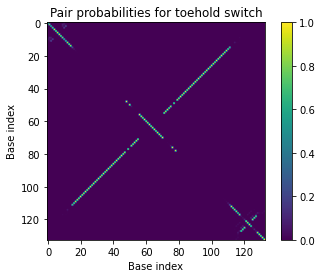

In [3]:
thsDisplay()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
trigger complex strand order and structure: 
['UCCUGUACUGAGCUGCCCCGAG', 'CUCGGGGAAAAAAUGGGAU', 'AUCCCACCUCUCACCAGC', 'GCUGGAAAAAAUUGCACA', 'UGUGCAAAUCCAUGCAAAACUGA']
By considering Boltzmann samples:  ...............(((((((+)))))))......((((((+)))))).......(((((+))))).......((((((+)))))).................
By considering MFE structure:  ...............(((((((+)))))))......((((((+)))))).......(((((+)))))......((((((.+.))))))................  Free energy:  -50.92  (kcal/nol)
with these other possible structures: 
...............(((((((+)))))))......((((((+)))))).......(((((+))))).......((((((+)))))).................
...............(((((((+)))))))......((((((+)))))).......(((((+))))).....((((((((+))))).)))..............
...............(((((((+)))))))......((((((+)))))).......(((((+))))).....((((((((+))))).)))..............
..((......))...(((((((+)))))))......((((((+)))))).......(((((+)))))......((((((.+.))))))........

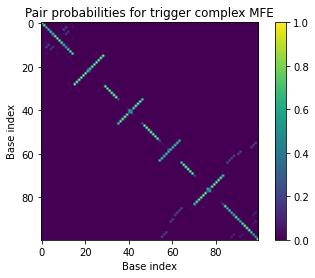

In [4]:
triggerDisplay()

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
actiavted toehold switch structure: 
((((((((((((((((((((((((((((((((((((((((((((((((+))))))))))))))))))))))))))))))))))))))))))))))))..................(((((((..........................)))))))............(((....))).....  Free energy:  -97.61  (kcal/mol)
with these other suboptimal energy structures: 
((((((((((((((((((((((((((((((((((((((((((((((((+))))))))))))))))))))))))))))))))))))))))))))))))..................(((((((..........................)))))))............(((....))).....  Free energy:  -97.61  (kcal/mol)
((((((((((((((((((((((((((((((((((((((((((((((((+))))))))))))))))))))))))))))))))))))))))))))))))..................(((((((..........................)))))))............(((....))).....  Free energy:  -97.61  (kcal/mol)
((((((((((((((((((((((((((((((((((((((((((((((((+))))))))))))))))))))))))))))))))))))))))))))))))..................(((((((..........................)))))))............(((....))).....  Free e

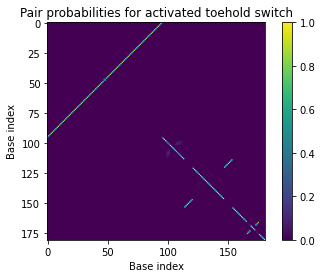

In [5]:
complexDisplay()

In [6]:
print("done")

done
